In [ ]:
import sys

sys.path.append("../")
import pandas as pd
from config.settings import MONGO_CONNECTION_STRING

from src.indicators.sma import calculate_sma
from pymongo import MongoClient

In [2]:
client = MongoClient(
    MONGO_CONNECTION_STRING,
    tls=True,
    tlsAllowInvalidCertificates=True,  # For development only
    # tlsCAFile='/Users/tyrelle/Desktop/4ex.ninja/4ex.ninja/config/global-bundle.pem'
)

In [3]:
db = client["forex_data"]
collections = db.list_collection_names()

In [4]:
# Choose a collection (for example EUR_USD_D)
collection_name = "EUR_USD_D"
collection = db[collection_name]

# Fetch all documents and convert to DataFrame
df_EURUSD_D = pd.DataFrame(list(collection.find()))

# Set the time column as the index
df_EURUSD_D.set_index("time", inplace=True)

# Extract OHLC values from the mid dictionary
df_EURUSD_D["open"] = df_EURUSD_D["mid"].apply(lambda x: float(x["o"]))
df_EURUSD_D["high"] = df_EURUSD_D["mid"].apply(lambda x: float(x["h"]))
df_EURUSD_D["low"] = df_EURUSD_D["mid"].apply(lambda x: float(x["l"]))
df_EURUSD_D["close"] = df_EURUSD_D["mid"].apply(lambda x: float(x["c"]))

# Drop unnecessary columns and reorder
df_EURUSD_D = df_EURUSD_D[["volume", "open", "high", "low", "close"]]

# Display information about the data
print(f"\nDataFrame info for {collection_name}:")
print(f"Total number of candles: {len(df_EURUSD_D)}")
print("\nFirst few rows:")
print(df_EURUSD_D.head())


DataFrame info for EUR_USD_D:
Total number of candles: 2595

First few rows:
                     volume     open     high      low    close
time                                                           
2025-02-04 22:00:00  156914  1.03758  1.04432  1.03696  1.04028
2025-02-05 22:00:00  136702  1.04049  1.04060  1.03526  1.03830
2025-02-06 22:00:00  183108  1.03858  1.04134  1.03052  1.03270
2025-02-09 22:00:00  112919  1.02925  1.03366  1.02838  1.03070
2025-02-10 22:00:00  119270  1.03092  1.03816  1.02922  1.03612


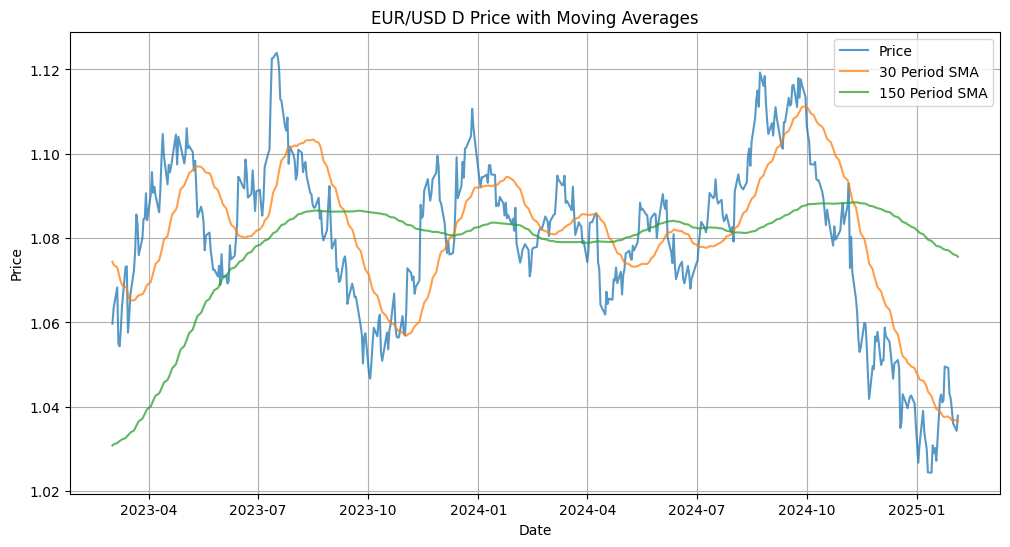

In [6]:
# Calculate moving averages
df_EURUSD_D["SMA_30"] = calculate_sma(df_EURUSD_D["close"], [30])[
    "sma_30"
]  # Pass period as a list
df_EURUSD_D["SMA_150"] = calculate_sma(df_EURUSD_D["close"], [150])[
    "sma_150"
]  # Pass period as a list

# Import plotting library
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df_EURUSD_D.index[-500:], df_EURUSD_D["close"][-500:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_D.index[-500:],
    df_EURUSD_D["SMA_30"][-500:],
    label="30 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_D.index[-500:],
    df_EURUSD_D["SMA_150"][-500:],
    label="150 Period SMA",
    alpha=0.75,
)

plt.title("EUR/USD D Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
import numpy as np


def identify_multiple_ma_crossovers(df, ma_pairs):
    """
    Identify MA crossover signals for multiple MA combinations

    Parameters:
    df : pandas DataFrame with price data
    ma_pairs : list of tuples, each containing (fast_period, slow_period)

    Returns:
    DataFrame with signals for each MA combination
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Calculate all required MAs
    for fast, slow in ma_pairs:
        df[f"SMA_{fast}"] = df["close"].rolling(window=fast).mean()
        df[f"SMA_{slow}"] = df["close"].rolling(window=slow).mean()

        # Generate signals for this MA pair
        signal_col = f"signal_{fast}_{slow}"
        df[signal_col] = np.where(
            (df[f"SMA_{fast}"] > df[f"SMA_{slow}"])
            & (df[f"SMA_{fast}"].shift(1) <= df[f"SMA_{slow}"].shift(1)),
            1,  # Buy signal
            np.where(
                (df[f"SMA_{fast}"] < df[f"SMA_{slow}"])
                & (df[f"SMA_{fast}"].shift(1) >= df[f"SMA_{slow}"].shift(1)),
                -1,  # Sell signal
                0,  # No signal
            ),
        )

    return df


# Example usage:
ma_pairs = [
    (10, 20),  
    (10, 30),  
    (10, 40), 
    (10, 50),
    (20, 30),
    (20, 40),
    (20, 50),
    (30, 40),
    (30, 50),
    (40, 50),
    (20, 10) 
]


# Apply to your DataFrame
df_with_signals = identify_multiple_ma_crossovers(df_EURUSD_D, ma_pairs)

# Print columns with signals
signal_columns = [col for col in df_with_signals.columns if col.startswith('signal_')]
print("\nSignal columns created:")
for col in signal_columns:
    print(f"- {col}")
    
# Example: Count signals for each MA pair
for col in signal_columns:
    buy_signals = (df_with_signals[col] == 1).sum()
    sell_signals = (df_with_signals[col] == -1).sum()
    print(f"\n{col}:")
    print(f"Buy signals: {buy_signals}")
    print(f"Sell signals: {sell_signals}")


Signal columns created:
- signal_10_20
- signal_10_30
- signal_10_40
- signal_10_50
- signal_20_30
- signal_20_40
- signal_20_50
- signal_30_40
- signal_30_50
- signal_40_50
- signal_20_10

signal_10_20:
Buy signals: 82
Sell signals: 82

signal_10_30:
Buy signals: 51
Sell signals: 50

signal_10_40:
Buy signals: 43
Sell signals: 42

signal_10_50:
Buy signals: 36
Sell signals: 36

signal_20_30:
Buy signals: 57
Sell signals: 58

signal_20_40:
Buy signals: 38
Sell signals: 38

signal_20_50:
Buy signals: 29
Sell signals: 29

signal_30_40:
Buy signals: 38
Sell signals: 39

signal_30_50:
Buy signals: 27
Sell signals: 27

signal_40_50:
Buy signals: 34
Sell signals: 35

signal_20_10:
Buy signals: 82
Sell signals: 82



Backtest Trade Results:
            entry_time           exit_time  entry_price  exit_price  signal  \
0  2015-11-10 22:00:00 2016-02-24 22:00:00      1.07435     1.10182    -1.0   
1  2016-02-24 22:00:00 2016-07-20 21:00:00      1.10182     1.10262     1.0   
2  2016-07-20 21:00:00 2016-09-07 21:00:00      1.10262     1.12614    -1.0   
3  2016-09-07 21:00:00 2016-09-29 21:00:00      1.12614     1.12425     1.0   
4  2016-09-29 21:00:00 2017-04-27 21:00:00      1.12425     1.08962    -1.0   
5  2017-04-27 21:00:00 2018-05-21 21:00:00      1.08962     1.17779     1.0   
6  2018-05-21 21:00:00 2020-01-09 22:00:00      1.17779     1.11205    -1.0   
7  2020-01-09 22:00:00 2020-02-10 22:00:00      1.11205     1.09153     1.0   
8  2020-02-10 22:00:00 2020-06-10 21:00:00      1.09153     1.12981    -1.0   
9  2020-06-10 21:00:00 2021-03-30 21:00:00      1.12981     1.17308     1.0   
10 2021-03-30 21:00:00 2021-05-12 21:00:00      1.17308     1.20790    -1.0   
11 2021-05-12 21:00:00 2021

In [18]:
def backtest_multiple_signals(df, signal_columns):
    """
    Backtest trades based on multiple MA crossover signals.
    Returns a dictionary of results for each MA combination.
    """
    results = {}
    
    for signal_col in signal_columns:
        trades = []
        open_trade = None
        
        # Create a copy of DataFrame for this signal
        df_temp = df.copy()
        
        for time, row in df_temp.iterrows():
            signal = row[signal_col]
            price = row["close"]
            
            # If there is a signal (non-zero)
            if signal != 0:
                # If no trade is open, open one
                if open_trade is None:
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }
                # If a trade is already open and the new signal is different (a reversal)
                elif signal != open_trade["signal"]:
                    exit_price = price
                    exit_time = time
                    if open_trade["signal"] == 1:  # Buy trade
                        pip_gain = (exit_price - open_trade["entry_price"]) * 10000
                    else:  # Sell trade
                        pip_gain = (open_trade["entry_price"] - exit_price) * 10000

                    trade = {
                        "entry_time": open_trade["entry_time"],
                        "exit_time": exit_time,
                        "entry_price": open_trade["entry_price"],
                        "exit_price": exit_price,
                        "signal": open_trade["signal"],
                        "pip_gain": pip_gain,
                    }
                    trades.append(trade)
                    # Open a new trade with the current signal
                    open_trade = {
                        "entry_time": time,
                        "entry_price": price,
                        "signal": signal,
                    }

        # If a trade is still open at the end, close it
        if open_trade is not None:
            last_time = df_temp.index[-1]
            last_price = df_temp.iloc[-1]["close"]
            if open_trade["signal"] == 1:
                pip_gain = (last_price - open_trade["entry_price"]) * 10000
            else:
                pip_gain = (open_trade["entry_price"] - last_price) * 10000
            trade = {
                "entry_time": open_trade["entry_time"],
                "exit_time": last_time,
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
            trades.append(trade)
            
        # Store results for this MA combination
        if trades:
            trades_df = pd.DataFrame(trades)
            total_pips = trades_df["pip_gain"].sum()
            num_trades = len(trades_df)
            avg_pips = trades_df["pip_gain"].mean()
            win_rate = (trades_df["pip_gain"] > 0).mean()
            
            results[signal_col] = {
                "trades": trades_df,
                "total_pips": total_pips,
                "num_trades": num_trades,
                "avg_pips": avg_pips,
                "win_rate": win_rate
            }
    
    return results

# Run backtest for all MA combinations
results = backtest_multiple_signals(df_with_signals, signal_columns)

# Print summary of results for each MA combination
print("\nBacktest Results Summary:")
print("-" * 80)
summary_data = []
for ma_combo, result in results.items():
    summary_data.append({
        "MA_Combo": ma_combo,
        "Total_Trades": result["num_trades"],
        "Total_Pips": round(result["total_pips"], 1),
        "Avg_Pips": round(result["avg_pips"], 1),
        "Win_Rate": f"{result['win_rate']*100:.1f}%"
    })

# Convert to DataFrame for better visualization
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Total_Pips", ascending=False)
print(summary_df)


Backtest Results Summary:
--------------------------------------------------------------------------------
        MA_Combo  Total_Trades  Total_Pips  Avg_Pips Win_Rate
10  signal_20_10           164      4787.0      29.2    66.5%
6   signal_20_50            58       947.2      16.3    39.7%
5   signal_20_40            76       899.5      11.8    39.5%
2   signal_10_40            85       876.8      10.3    34.1%
3   signal_10_50            72       754.0      10.5    34.7%
9   signal_40_50            69       536.6       7.8    39.1%
8   signal_30_50            54       308.0       5.7    29.6%
7   signal_30_40            77       217.4       2.8    39.0%
4   signal_20_30           115       126.2       1.1    40.9%
1   signal_10_30           101      -971.1      -9.6    35.6%
0   signal_10_20           164     -4787.0     -29.2    33.5%



Realistic Backtest Results:
Total Trades: 160
Total Pips: 1904.4
Average Pips per Trade: 11.9
Win Rate: 42.5%
Sharpe Ratio: 2.94

Exit Analysis:
----------------------------------------
Exit Type Distribution:
sl: 92 trades (0.0% win rate)
tp: 68 trades (100.0% win rate)

Risk Metrics:
----------------------------------------
Profit Factor: 1.51
Maximum Drawdown: 359.9 pips


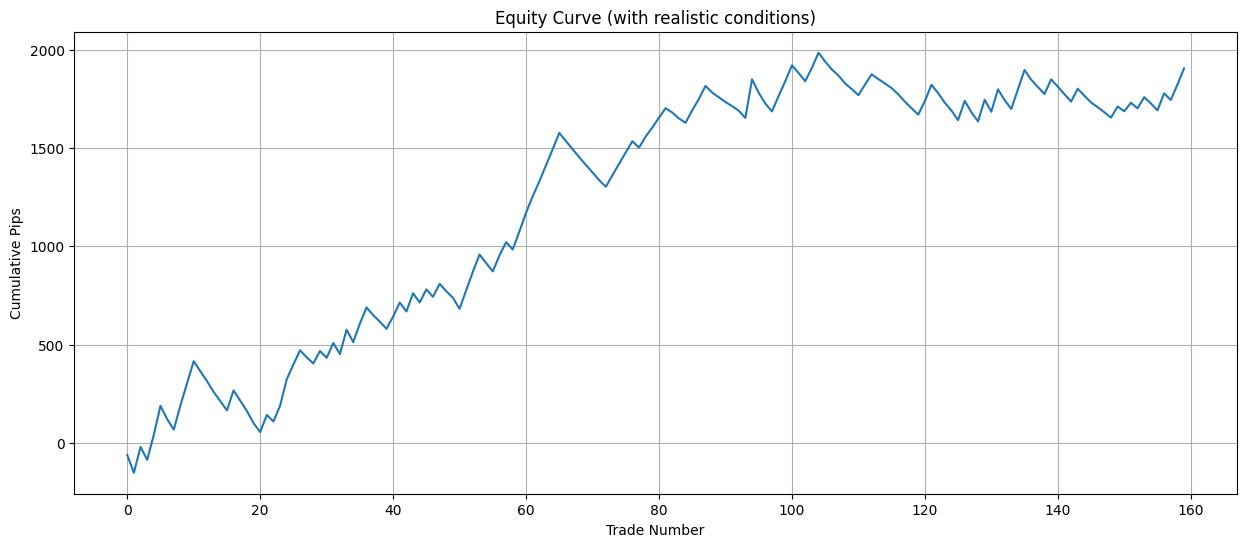

In [31]:
# def realistic_backtest(df, signal_col, spread_pips=1.0):
#     """
#     Realistic backtest with spread costs and next-bar execution
#     """
#     df = df.copy()
#     trades = []
#     open_trade = None

#     for i in range(len(df) - 1):  # -1 to allow next-bar execution
#         current_row = df.iloc[i]
#         next_row = df.iloc[i + 1]  # Next bar for execution

#         signal = current_row[signal_col]

#         # Handle open trade
#         if open_trade is not None:
#             if signal != 0 and signal != open_trade["signal"]:
#                 # Exit price includes spread
#                 exit_price = next_row["open"]  # Use next bar's open for exit
#                 if open_trade["signal"] == 1:
#                     exit_price -= spread_pips * 0.0001  # Subtract spread for selling
#                     pip_gain = (exit_price - open_trade["entry_price"]) * 10000
#                 else:
#                     exit_price += spread_pips * 0.0001  # Add spread for buying
#                     pip_gain = (open_trade["entry_price"] - exit_price) * 10000

#                 trades.append(
#                     {
#                         "entry_time": open_trade["entry_time"],
#                         "exit_time": next_row.name,
#                         "entry_price": open_trade["entry_price"],
#                         "exit_price": exit_price,
#                         "signal": open_trade["signal"],
#                         "pip_gain": pip_gain,
#                     }
#                 )
#                 open_trade = None


def calculate_atr(df, period=14):
    """
    Calculate Average True Range (ATR)

    Parameters:
    - df: DataFrame with high, low, close prices
    - period: Period for ATR calculation, default 14

    Returns:
    - Series containing ATR values
    """
    df = df.copy()

    # Calculate True Range
    df["tr1"] = df["high"] - df["low"]
    df["tr2"] = abs(df["high"] - df["close"].shift(1))
    df["tr3"] = abs(df["low"] - df["close"].shift(1))

    df["tr"] = df[["tr1", "tr2", "tr3"]].max(axis=1)

    # Calculate ATR
    atr = df["tr"].rolling(window=period).mean()

    return atr


def realistic_backtest_with_risk_management(
    df, signal_col, spread_pips=1.0, tp_atr=1.0, sl_atr=0.5, atr_period=14
):
    """
    Add ATR-based stops and targets to realistic backtest
    """
    df = df.copy()
    df["atr"] = calculate_atr(df, atr_period)
    trades = []
    open_trade = None

    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        signal = current_row[signal_col]
        current_atr = current_row["atr"]

        # Handle open trade
        if open_trade is not None:
            # Calculate take-profit and stop-loss levels
            if open_trade["signal"] == 1:
                take_profit = open_trade["entry_price"] + (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] - (current_atr * sl_atr)
                # Check if TP or SL hit
                if next_row["high"] >= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["low"] <= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue
            else:
                take_profit = open_trade["entry_price"] - (current_atr * tp_atr)
                stop_loss = open_trade["entry_price"] + (current_atr * sl_atr)
                if next_row["low"] <= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["high"] >= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl"
                else:
                    continue

            pip_gain = (exit_price - open_trade["entry_price"]) * 10000
            if open_trade["signal"] == -1:
                pip_gain = -pip_gain

            trades.append(
                {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": next_row.name,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": open_trade["signal"],
                    "pip_gain": pip_gain,
                    "exit_type": exit_type,
                }
            )
            open_trade = None

        # Open new trade
        if signal != 0 and open_trade is None:
            entry_price = next_row["open"]  # Use next bar's open for entry
            if signal == 1:
                entry_price += spread_pips * 0.0001  # Add spread for buying
            else:
                entry_price -= spread_pips * 0.0001  # Subtract spread for selling

            open_trade = {
                "entry_time": next_row.name,
                "entry_price": entry_price,
                "signal": signal,
            }

    # Close any remaining trade
    if open_trade is not None:
        last_price = df.iloc[-1]["close"]
        if open_trade["signal"] == 1:
            last_price -= spread_pips * 0.0001
            pip_gain = (last_price - open_trade["entry_price"]) * 10000
        else:
            last_price += spread_pips * 0.0001
            pip_gain = (open_trade["entry_price"] - last_price) * 10000

        trades.append(
            {
                "entry_time": open_trade["entry_time"],
                "exit_time": df.index[-1],
                "entry_price": open_trade["entry_price"],
                "exit_price": last_price,
                "signal": open_trade["signal"],
                "pip_gain": pip_gain,
            }
        )

    trades_df = pd.DataFrame(trades)

    # Calculate daily returns for Sharpe Ratio
    if not trades_df.empty:
        daily_returns = trades_df.groupby("exit_time")["pip_gain"].sum()
        avg_return = daily_returns.mean()
        std_return = daily_returns.std()
        sharpe_ratio = np.sqrt(252) * avg_return / std_return if std_return != 0 else 0

        results = {
            "total_pips": trades_df["pip_gain"].sum(),
            "num_trades": len(trades_df),
            "win_rate": (trades_df["pip_gain"] > 0).mean(),
            "avg_pips": trades_df["pip_gain"].mean(),
            "sharpe_ratio": sharpe_ratio,
            "trades": trades_df,
        }
    else:
        results = {
            "total_pips": 0,
            "num_trades": 0,
            "win_rate": 0,
            "avg_pips": 0,
            "sharpe_ratio": 0,
            "trades": trades_df,
        }

    return results


# Run realistic backtest
realistic_results = realistic_backtest_with_risk_management(
    df_with_signals, "signal_20_10"
)

print("\nRealistic Backtest Results:")
print(f"Total Trades: {realistic_results['num_trades']}")
print(f"Total Pips: {realistic_results['total_pips']:.1f}")
print(f"Average Pips per Trade: {realistic_results['avg_pips']:.1f}")
print(f"Win Rate: {realistic_results['win_rate']*100:.1f}%")
print(f"Sharpe Ratio: {realistic_results['sharpe_ratio']:.2f}")

# After the existing results printing
if len(realistic_results["trades"]) > 0:
    trades_df = realistic_results["trades"]

    # Exit type analysis
    exit_counts = trades_df["exit_type"].value_counts()
    exit_wins = trades_df[trades_df["pip_gain"] > 0]["exit_type"].value_counts()

    print("\nExit Analysis:")
    print("-" * 40)
    print("Exit Type Distribution:")
    for exit_type in exit_counts.index:
        win_count = exit_wins.get(exit_type, 0)
        total_count = exit_counts[exit_type]
        win_rate = (win_count / total_count * 100) if total_count > 0 else 0
        print(f"{exit_type}: {total_count} trades ({win_rate:.1f}% win rate)")

    # Risk metrics
    profit_factor = abs(
        trades_df[trades_df["pip_gain"] > 0]["pip_gain"].sum()
        / trades_df[trades_df["pip_gain"] < 0]["pip_gain"].sum()
    )
    max_drawdown = (
        trades_df["pip_gain"].cumsum()
        - trades_df["pip_gain"].cumsum().expanding().max()
    ).min()

    print("\nRisk Metrics:")
    print("-" * 40)
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Maximum Drawdown: {abs(max_drawdown):.1f} pips")

# Plot equity curve
if len(realistic_results["trades"]) > 0:
    plt.figure(figsize=(15, 6))
    equity_curve = realistic_results["trades"]["pip_gain"].cumsum()
    plt.plot(equity_curve.index, equity_curve)
    plt.title("Equity Curve (with realistic conditions)")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Pips")
    plt.grid(True)
    plt.show()

In [30]:
def analyze_performance(trades_df):
    """
    Calculate detailed performance metrics
    """
    if trades_df.empty:
        return {}
        
    # Monthly returns
    monthly_returns = trades_df.set_index('exit_time')['pip_gain'].resample('M').sum()
    
    # Drawdown analysis
    cumulative = trades_df['pip_gain'].cumsum()
    rolling_max = cumulative.expanding().max()
    drawdowns = cumulative - rolling_max
    
    return {
        "sharpe_ratio": realistic_results['sharpe_ratio'],
        "max_drawdown": drawdowns.min(),
        "profit_factor": abs(trades_df[trades_df['pip_gain'] > 0]['pip_gain'].sum() / 
                           trades_df[trades_df['pip_gain'] < 0]['pip_gain'].sum()),
        "avg_win": trades_df[trades_df['pip_gain'] > 0]['pip_gain'].mean(),
        "avg_loss": abs(trades_df[trades_df['pip_gain'] < 0]['pip_gain'].mean()),
        "monthly_returns": monthly_returns
    }

In [38]:
def realistic_backtest_with_trailing_stops(
    df,
    signal_col,
    spread_pips=1.0,
    tp_atr=1.0,
    sl_atr=0.5,
    trail_atr=0.3,  # Trailing stop ATR multiplier
    trail_activation=0.3,  # Activate trailing stop after this ATR multiple of profit
    atr_period=14,
):
    """
    Enhanced backtest with ATR-based trailing stops
    """
    df = df.copy()
    df["atr"] = calculate_atr(df, atr_period)
    trades = []
    open_trade = None

    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        signal = current_row[signal_col]
        current_atr = current_row["atr"]

        # Handle open trade
        if open_trade is not None:
            # Calculate take-profit and initial stop-loss
            if open_trade["signal"] == 1:
                take_profit = open_trade["entry_price"] + (current_atr * tp_atr)
                initial_stop = open_trade["entry_price"] - (current_atr * sl_atr)

                # Calculate trailing stop if in profit
                current_profit = next_row["open"] - open_trade["entry_price"]
                if current_profit > (current_atr * trail_activation):
                    trail_level = next_row["open"] - (current_atr * trail_atr)
                    stop_loss = max(trail_level, initial_stop)
                else:
                    stop_loss = initial_stop

                # Check exits
                if next_row["high"] >= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["low"] <= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl" if stop_loss == initial_stop else "trail"
                else:
                    continue
            else:
                take_profit = open_trade["entry_price"] - (current_atr * tp_atr)
                initial_stop = open_trade["entry_price"] + (current_atr * sl_atr)

                # Calculate trailing stop if in profit
                current_profit = open_trade["entry_price"] - next_row["open"]
                if current_profit > (current_atr * trail_activation):
                    trail_level = next_row["open"] + (current_atr * trail_atr)
                    stop_loss = min(trail_level, initial_stop)
                else:
                    stop_loss = initial_stop

                # Check exits
                if next_row["low"] <= take_profit:
                    exit_price = take_profit
                    exit_type = "tp"
                elif next_row["high"] >= stop_loss:
                    exit_price = stop_loss
                    exit_type = "sl" if stop_loss == initial_stop else "trail"
                else:
                    continue

            pip_gain = (exit_price - open_trade["entry_price"]) * 10000
            if open_trade["signal"] == -1:
                pip_gain = -pip_gain

            trades.append(
                {
                    "entry_time": open_trade["entry_time"],
                    "exit_time": next_row.name,
                    "entry_price": open_trade["entry_price"],
                    "exit_price": exit_price,
                    "signal": open_trade["signal"],
                    "pip_gain": pip_gain,
                    "exit_type": exit_type,
                }
            )
            open_trade = None

        # Open new trade
        if signal != 0 and open_trade is None:
            entry_price = next_row["open"]
            if signal == 1:
                entry_price += spread_pips * 0.0001
            else:
                entry_price -= spread_pips * 0.0001

            open_trade = {
                "entry_time": next_row.name,
                "entry_price": entry_price,
                "signal": signal,
            }

    return trades


# Test the enhanced strategy
realistic_results = realistic_backtest_with_trailing_stops(
    df_with_signals,
    "signal_20_10",
    tp_atr=1.0,
    sl_atr=0.5,
    trail_atr=0.3,
    trail_activation=0.3,
)


# Convert trades list to DataFrame and calculate metrics
trades_df = pd.DataFrame(realistic_results)

if not trades_df.empty:
    # Calculate daily returns for Sharpe Ratio
    daily_returns = trades_df.groupby("exit_time")["pip_gain"].sum()
    sharpe_ratio = (
        np.sqrt(252) * daily_returns.mean() / daily_returns.std()
        if daily_returns.std() != 0
        else 0
    )

    # Basic metrics
    print("\nRealistic Backtest Results with Trailing Stops:")
    print("-" * 60)
    print(f"Total Trades: {len(trades_df)}")
    print(f"Total Pips: {trades_df['pip_gain'].sum():.1f}")
    print(f"Average Pips per Trade: {trades_df['pip_gain'].mean():.1f}")
    print(f"Win Rate: {(trades_df['pip_gain'] > 0).mean()*100:.1f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    # Exit type analysis
    print("\nExit Analysis:")
    print("-" * 60)
    exit_counts = trades_df["exit_type"].value_counts()
    exit_wins = trades_df[trades_df["pip_gain"] > 0]["exit_type"].value_counts()

    for exit_type in exit_counts.index:
        win_count = exit_wins.get(exit_type, 0)
        total_count = exit_counts[exit_type]
        win_rate = (win_count / total_count * 100) if total_count > 0 else 0
        avg_gain = trades_df[trades_df["exit_type"] == exit_type]["pip_gain"].mean()
        print(
            f"{exit_type}: {total_count} trades ({win_rate:.1f}% win rate, avg {avg_gain:.1f} pips)"
        )

    # Risk metrics
    profit_factor = abs(
        trades_df[trades_df["pip_gain"] > 0]["pip_gain"].sum()
        / trades_df[trades_df["pip_gain"] < 0]["pip_gain"].sum()
    )
    max_drawdown = (
        trades_df["pip_gain"].cumsum()
        - trades_df["pip_gain"].cumsum().expanding().max()
    ).min()

    print("\nRisk Metrics:")
    print("-" * 60)
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Maximum Drawdown: {abs(max_drawdown):.1f} pips")


Realistic Backtest Results with Trailing Stops:
------------------------------------------------------------
Total Trades: 163
Total Pips: 2312.1
Average Pips per Trade: 14.2
Win Rate: 52.8%
Sharpe Ratio: 3.77

Exit Analysis:
------------------------------------------------------------
sl: 77 trades (0.0% win rate, avg -40.9 pips)
tp: 60 trades (100.0% win rate, avg 82.8 pips)
trail: 26 trades (100.0% win rate, avg 19.0 pips)

Risk Metrics:
------------------------------------------------------------
Profit Factor: 1.73
Maximum Drawdown: 273.8 pips


In [39]:
# Test different parameter combinations
param_combinations = [
    {'tp_atr': 1.2, 'sl_atr': 0.6, 'trail_atr': 0.4, 'trail_activation': 0.3},
    {'tp_atr': 1.0, 'sl_atr': 0.4, 'trail_atr': 0.3, 'trail_activation': 0.2},
    {'tp_atr': 0.8, 'sl_atr': 0.5, 'trail_atr': 0.2, 'trail_activation': 0.2}
]

results = []
for params in param_combinations:
    trades = realistic_backtest_with_trailing_stops(
        df_with_signals,
        "signal_20_10",
        tp_atr=params['tp_atr'],
        sl_atr=params['sl_atr'],
        trail_atr=params['trail_atr'],
        trail_activation=params['trail_activation']
    )
    trades_df = pd.DataFrame(trades)
    
    if not trades_df.empty:
        daily_returns = trades_df.groupby('exit_time')['pip_gain'].sum()
        sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
        
        results.append({
            'params': params,
            'total_pips': trades_df['pip_gain'].sum(),
            'win_rate': (trades_df['pip_gain'] > 0).mean() * 100,
            'sharpe': sharpe,
            'max_dd': (trades_df['pip_gain'].cumsum() - 
                      trades_df['pip_gain'].cumsum().expanding().max()).min()
        })

# Display results as DataFrame
results_df = pd.DataFrame([{**r['params'], 
                           'Total Pips': r['total_pips'],
                           'Win Rate %': r['win_rate'],
                           'Sharpe': r['sharpe'],
                           'Max DD': abs(r['max_dd'])} 
                          for r in results])
print("\nParameter Optimization Results:")
print(results_df.round(2))


Parameter Optimization Results:
   tp_atr  sl_atr  trail_atr  trail_activation  Total Pips  Win Rate %  \
0     1.2     0.6        0.4               0.3     1908.06       48.75   
1     1.0     0.4        0.3               0.2     2623.21       48.78   
2     0.8     0.5        0.2               0.2     1922.52       57.32   

   Sharpe  Max DD  
0    2.85  257.76  
1    4.62  236.33  
2    3.61  255.89  


In [40]:
# Fine-tune around best parameters
fine_tune_params = [
    {'tp_atr': 1.0, 'sl_atr': 0.4, 'trail_atr': 0.3, 'trail_activation': 0.2},  # Best so far
    {'tp_atr': 1.0, 'sl_atr': 0.35, 'trail_atr': 0.3, 'trail_activation': 0.2}, # Tighter SL
    {'tp_atr': 1.1, 'sl_atr': 0.4, 'trail_atr': 0.25, 'trail_activation': 0.2}, # Higher TP
    {'tp_atr': 1.0, 'sl_atr': 0.4, 'trail_atr': 0.25, 'trail_activation': 0.15}  # Earlier trail
]

results = []
for params in fine_tune_params:
    trades = realistic_backtest_with_trailing_stops(
        df_with_signals,
        "signal_20_10",
        **params
    )
    trades_df = pd.DataFrame(trades)
    
    if not trades_df.empty:
        daily_returns = trades_df.groupby('exit_time')['pip_gain'].sum()
        sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
        
        # Calculate additional metrics
        profit_factor = abs(
            trades_df[trades_df['pip_gain'] > 0]['pip_gain'].sum() /
            trades_df[trades_df['pip_gain'] < 0]['pip_gain'].sum()
        )
        
        results.append({
            'params': params,
            'total_pips': trades_df['pip_gain'].sum(),
            'win_rate': (trades_df['pip_gain'] > 0).mean() * 100,
            'sharpe': sharpe,
            'max_dd': (trades_df['pip_gain'].cumsum() - 
                      trades_df['pip_gain'].cumsum().expanding().max()).min(),
            'profit_factor': profit_factor
        })

# Display results with more metrics
results_df = pd.DataFrame([{
    **r['params'], 
    'Total Pips': r['total_pips'],
    'Win Rate %': r['win_rate'],
    'Sharpe': r['sharpe'],
    'Max DD': abs(r['max_dd']),
    'Profit Factor': r['profit_factor']
} for r in results])

print("\nFine-Tuned Parameter Results:")
print(results_df.round(2).sort_values('Sharpe', ascending=False))


Fine-Tuned Parameter Results:
   tp_atr  sl_atr  trail_atr  trail_activation  Total Pips  Win Rate %  \
1     1.0    0.35       0.30              0.20     2921.32       48.78   
2     1.1    0.40       0.25              0.20     2835.66       51.53   
3     1.0    0.40       0.25              0.15     2578.65       51.22   
0     1.0    0.40       0.30              0.20     2623.21       48.78   

   Sharpe  Max DD  Profit Factor  
1    5.31  203.07           2.29  
2    4.94  228.16           2.16  
3    4.65  228.16           2.04  
0    4.62  236.33           2.02  


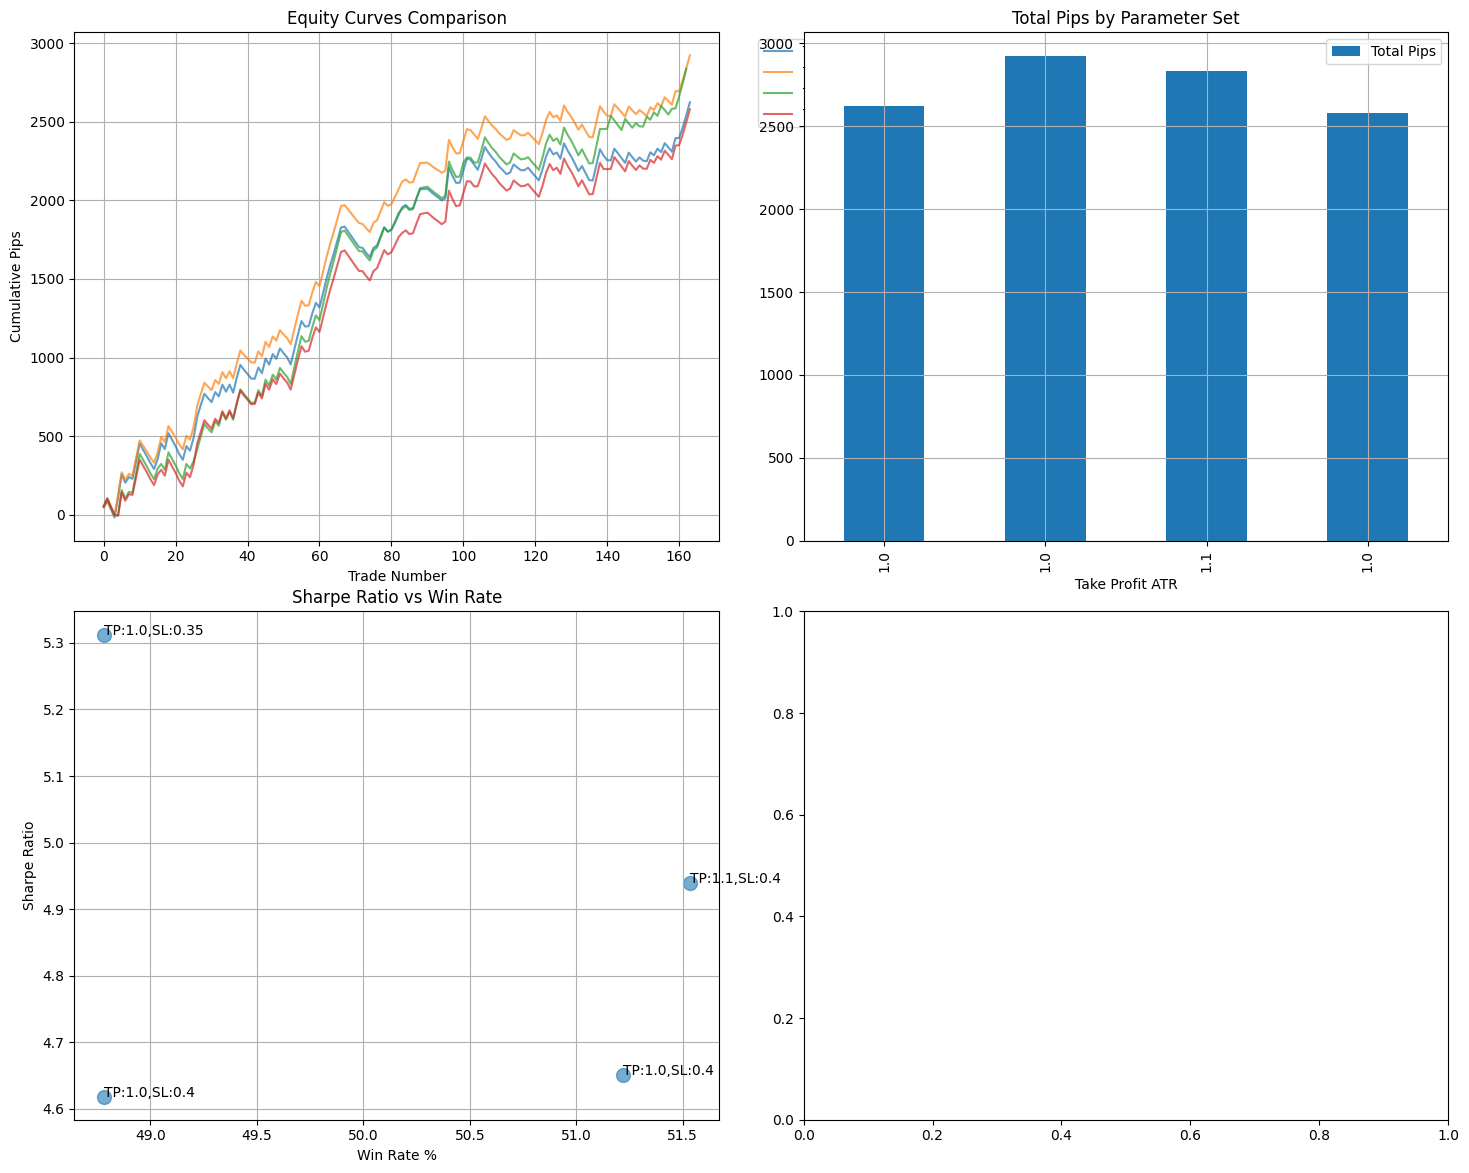

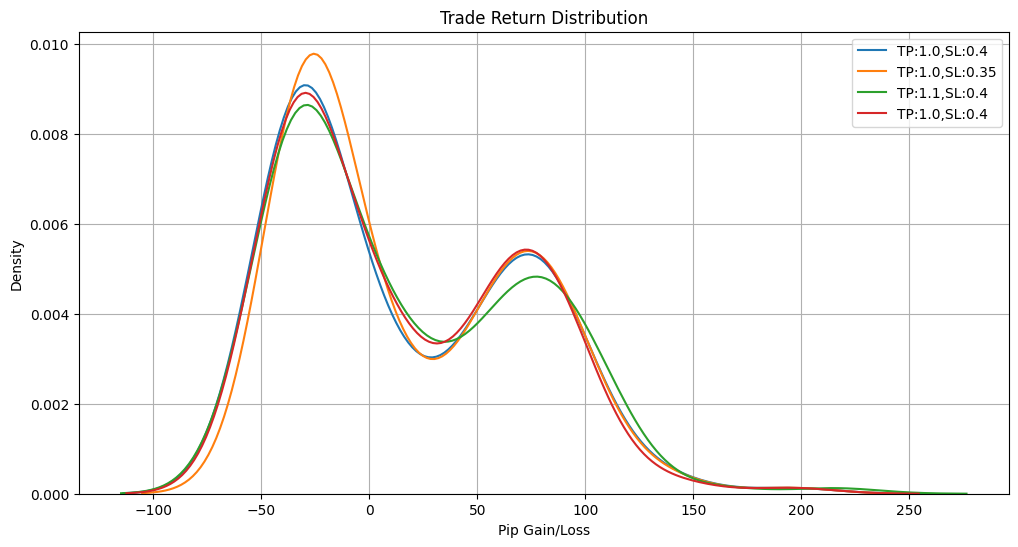

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for different metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.tight_layout(pad=3.0)  # Fixed the typo here (removed 'sounding_')

# Plot equity curves for each parameter set
for params in fine_tune_params:
    trades = realistic_backtest_with_trailing_stops(
        df_with_signals, "signal_20_10", **params
    )
    trades_df = pd.DataFrame(trades)

    if not trades_df.empty:
        # Equity curve
        equity_curve = trades_df["pip_gain"].cumsum()
        label = f"TP:{params['tp_atr']},SL:{params['sl_atr']}"
        ax1.plot(equity_curve.index, equity_curve, label=label, alpha=0.7)
# Equity Curves
ax1.set_title("Equity Curves Comparison")
ax1.set_xlabel("Trade Number")
ax1.set_ylabel("Cumulative Pips")
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.grid(True)

# Bar plot of Total Pips
results_df.plot(kind="bar", x="tp_atr", y="Total Pips", ax=ax2)
ax2.set_title("Total Pips by Parameter Set")
ax2.set_xlabel("Take Profit ATR")
ax2.grid(True)

# Scatter plot of Sharpe vs Win Rate
ax3.scatter(results_df["Win Rate %"], results_df["Sharpe"], s=100, alpha=0.6)
for i, row in results_df.iterrows():
    ax3.annotate(
        f"TP:{row['tp_atr']},SL:{row['sl_atr']}", (row["Win Rate %"], row["Sharpe"])
    )
ax3.set_title("Sharpe Ratio vs Win Rate")
ax3.set_xlabel("Win Rate %")
ax3.set_ylabel("Sharpe Ratio")
ax3.grid(True)

# # Max Drawdown comparison
# ax4.bar(results_df["tp_atr"].astype(str), results_df["Max DD"])
# ax4.set_title("Maximum Drawdown by Parameter Set")
# ax4.set_xlabel("Take Profit ATR")
# ax4.set_ylabel("Max Drawdown (Pips)")
# ax4.grid(True)

plt.show()

# Additional visualization for trade distribution
plt.figure(figsize=(12, 6))
for params in fine_tune_params:
    trades = realistic_backtest_with_trailing_stops(
        df_with_signals, "signal_20_10", **params
    )
    trades_df = pd.DataFrame(trades)

    if not trades_df.empty:
        sns.kdeplot(
            data=trades_df["pip_gain"],
            label=f"TP:{params['tp_atr']},SL:{params['sl_atr']}",
        )

plt.title("Trade Return Distribution")
plt.xlabel("Pip Gain/Loss")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()